In [2]:
#############################################
#import 
#############################################
import os
import sys
import torch
import logging
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import numpy as np
import math
__file__ = "find_TP.ipynb"
sys.path.append(os.path.join(os.path.dirname(__file__), '../'))
#from config.test_config import get_config_test
from models.pipeline_factory import get_pipeline
from models.pipelines.pipeline_utils import *

In [2]:
# nuage ID
#query_idx = 3573 TP_id = 1er
query_idx = 5493 # TP = 34eme

In [3]:
def positional_encoding(pos, d_model=512):
    pe = np.zeros((1, d_model))
    for i in range(0, d_model, 2):
        pe[0][i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
        pe[0][i+1] = math.cos(pos / (10000 ** ((2 * i)/d_model)))
    return pe
# Assume y1 is the embedding vector for "soar"
y1 = np.array([0.12, -0.48, 0.85, ..., -0.03])  # This should have 512 elements
pe = positional_encoding(1)
pc = y1 + pe  # Element-wise addition

<class 'ValueError'>: operands could not be broadcast together with shapes (5,) (1,512) 

In [3]:
import argparse

arg_lists = []
parser = argparse.ArgumentParser()

def add_argument_group(name):
    arg = parser.add_argument_group(name)
    arg_lists.append(arg)
    return arg

def str2bool(v):
    return v.lower() in ('true', '1')

# Evaluation
test_arg = add_argument_group('Eval')
test_arg.add_argument('--eval_pipeline', type=str, default='LOGG3D')
#test_arg.add_argument('--eval_pipeline', type=str, default='PointNetVLAD')
test_arg.add_argument('--kitti_eval_seq', type=int, default=6)
test_arg.add_argument('--mulran_eval_seq', type=str,default='DCC/DCC_02')
#test_arg.add_argument('--checkpoint_name', type=str,default='/kitti_10cm_loo/2021-09-14_20-28-22_3n24h_Kitti_v10_q29_10s8_263169.pth')

#test_arg.add_argument('--checkpoint_name', type=str,default='/logg_epoc_10_kit_check')

test_arg.add_argument('--checkpoint_name', type=str,default='/logg_epoc_31_mulran')


test_arg.add_argument('--eval_batch_size', type=int, default=1)
test_arg.add_argument('--test_num_workers', type=int, default=3)
test_arg.add_argument("--eval_random_rotation", type=str2bool,default=False, help="If random rotation. ")
test_arg.add_argument("--eval_random_occlusion", type=str2bool,default=False, help="If random occlusion. ")

test_arg.add_argument("--revisit_criteria", default=3,
                      type=float, help="in meters")
test_arg.add_argument("--not_revisit_criteria",
                      default=20, type=float, help="in meters")

test_arg.add_argument("--skip_time", default=30, type=float, help="in seconds")
test_arg.add_argument("--cd_thresh_min", default=0.001,
                      type=float, help="Thresholds on cosine-distance to top-1.")

test_arg.add_argument("--cd_thresh_max", default=1.0,
                      type=float, help="Thresholds on cosine-distance to top-1.")

test_arg.add_argument("--num_thresholds", default=1000, type=int,
                      help="Number of thresholds. Number of points on PR curve.")


# Dataset specific configurations
data_arg = add_argument_group('Data')
# KittiDataset #MulRanDataset
#data_arg.add_argument('--eval_dataset', type=str, default='KittiDataset')
data_arg.add_argument('--eval_dataset', type=str, default='MulRanDataset')
data_arg.add_argument('--collation_type', type=str,
                      default='default')  # default#sparcify_list
data_arg.add_argument("--eval_save_descriptors", type=str2bool, default=False)
data_arg.add_argument("--eval_save_counts", type=str2bool, default=False)
data_arg.add_argument("--eval_plot_pr_curve", type=str2bool, default=True)
data_arg.add_argument('--num_points', type=int, default=80000)
data_arg.add_argument('--voxel_size', type=float, default=0.10)
data_arg.add_argument("--gp_rem", type=str2bool,
                      default=False, help="Remove ground plane.")
data_arg.add_argument('--eval_feature_distance', type=str,
                      default='cosine')  # cosine#euclidean
data_arg.add_argument("--pnv_preprocessing", type=str2bool,
                      default=False, help="Preprocessing in dataloader for PNV.")

data_arg.add_argument('--kitti_dir', type=str, default='/gpfswork/rech/dki/ujo91el/datas/dataset/',help="Path to the KITTI odometry dataset")
data_arg.add_argument('--kitti_data_split', type=dict, default={
    'train': [0, 1, 2, 3, 4, 5, 6, 7, 9, 10],
    'val': [],
    'test': [8]
})

data_arg.add_argument('--mulran_dir', type=str,default='/gpfswork/rech/dki/ujo91el/datas/mulran/', help="Path to the MulRan dataset")

data_arg.add_argument("--mulran_normalize_intensity", type=str2bool,default=False, help="Normalize intensity return.")

data_arg.add_argument('--mulran_data_split', type=dict, default={
    'train': ['DCC/DCC_01', 'DCC/DCC_02',
              'Riverside/Riverside_01', 'Riverside/Riverside_03'],
    'val': [],
    'test': ['KAIST/KAIST_01']
})


# Data loader configs
data_arg.add_argument('--train_phase', type=str, default="train")
data_arg.add_argument('--val_phase', type=str, default="val")
data_arg.add_argument('--test_phase', type=str, default="test")
data_arg.add_argument('--use_random_rotation', type=str2bool, default=True)
data_arg.add_argument('--rotation_range', type=float, default=360)
data_arg.add_argument('--use_random_occlusion', type=str2bool, default=True)
data_arg.add_argument('--occlusion_angle', type=float, default=30)
data_arg.add_argument('--use_random_scale', type=str2bool, default=False)
data_arg.add_argument('--min_scale', type=float, default=0.8)
data_arg.add_argument('--max_scale', type=float, default=1.2)


def get_config_test():
    #args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    return args

In [4]:
#############################################
#dataloading
#############################################
# Get config
cfg = get_config_test()
print("cfg.eval_dataset",cfg.eval_dataset)
if 'Kitti' in cfg.eval_dataset:
    print("cfg.kitti_eval_seq", cfg.kitti_eval_seq)
elif 'MulRan' in cfg.eval_dataset:
    print("cfg.mulran_eval_seq", cfg.mulran_eval_seq)
print("cfg.checkpoint_name", cfg.checkpoint_name)

cfg.eval_dataset MulRanDataset
cfg.mulran_eval_seq DCC/DCC_02
cfg.checkpoint_name /logg_epoc_31_mulran


descriptor_path /gpfswork/rech/dki/ujo91el/code/logg3dnet/evaluation/DCC/DCC_02/logg3d_descriptor.pickle
input_file <_io.BufferedReader name='/gpfswork/rech/dki/ujo91el/code/logg3dnet/evaluation/classification/DCC/DCC_02_seq_TP_dataset_MulRanDataset.pkl'>
TP_idx 2184
fname /gpfswork/rech/dki/ujo91el/datas/mulran/DCC/DCC_02/Ouster/1566534352781928563.bin query_idx 5493
fname /gpfswork/rech/dki/ujo91el/datas/mulran/DCC/DCC_02/Ouster/1566534021887587836.bin query_idx 2184


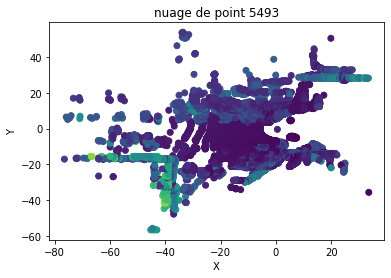

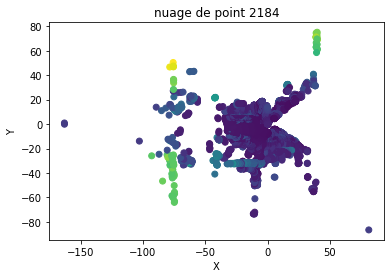

In [5]:
#Adapt name
if 'Kitti' in cfg.eval_dataset:
    eval_seq = cfg.kitti_eval_seq
    eval_seq = '%02d' % eval_seq

elif 'MulRan' in cfg.eval_dataset:
    eval_seq = cfg.mulran_eval_seq
    
    #check name for mulran
    name_file = open("/gpfswork/rech/dki/ujo91el/code/logg3dnet/evaluation/classification/"+str(cfg.mulran_eval_seq)+"_Names_MulRanDataset.pkl", "rb")
    name_dict = pickle.load(name_file)

seq = str(eval_seq)
dat = str(cfg.eval_dataset)


#check descriptor.pkl
descriptor_path = "/gpfswork/rech/dki/ujo91el/code/logg3dnet/evaluation/"+seq+"/logg3d_descriptor.pickle"
print("descriptor_path", descriptor_path)
input_file = open(descriptor_path, "rb")
seen_descriptors = pickle.load(input_file)
db_seen_descriptors = np.copy(seen_descriptors)


#check pairing_TP.pkl
TP_file = open("/gpfswork/rech/dki/ujo91el/code/logg3dnet/evaluation/classification/"+seq+'_seq_TP_dataset_'+dat+'.pkl', "rb")
print("input_file", TP_file)
dict_TP = pickle.load(TP_file)
TP_idx = dict_TP[query_idx] 
print("TP_idx", TP_idx)

#nuage
og_name = name_dict[query_idx]
if 'Kitti' in cfg.eval_dataset:
    fname = cfg.kitti_dir + 'sequences/'+seq+'/velodyne/'+'%06d' % query_idx + '.bin'

elif 'MulRan' in cfg.eval_dataset:
    fname = '/gpfswork/rech/dki/ujo91el/datas/mulran/'+seq+'/Ouster/'+str(og_name)+'.bin'
print("fname",fname, "query_idx", query_idx)
xyzr = np.fromfile(fname, dtype=np.float32).reshape(-1, 4)
rang = np.linalg.norm(xyzr[:, :3], axis=1)
range_filter = np.logical_and(rang > 0.1, rang < 80)
xyzr = xyzr[range_filter]

#nuage TP
og_name_TP = name_dict[TP_idx]
if 'Kitti' in cfg.eval_dataset:
    fname_TP = cfg.kitti_dir + 'sequences/'+seq+'/velodyne/'+'%06d' % TP_idx + '.bin'

elif 'MulRan' in cfg.eval_dataset:
    fname_TP = '/gpfswork/rech/dki/ujo91el/datas/mulran/'+seq+'/Ouster/'+str(og_name_TP)+'.bin'
print("fname",fname_TP, "query_idx", TP_idx)
xyz_TP = np.fromfile(fname_TP, dtype=np.float32).reshape(-1, 4)
rang_TP = np.linalg.norm(xyz_TP[:, :3], axis=1)
range_filter_TP = np.logical_and(rang > 0.1, rang < 80)
xyz_TP = xyz_TP[range_filter]


plt.figure()
plt.scatter(xyzr[:, 0], xyzr[:, 1], c=xyzr[:, 2])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("nuage de point "+str(query_idx))
plt.show()


plt.figure()
plt.scatter(xyz_TP[:, 0], xyz_TP[:, 1], c=xyz_TP[:, 2])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("nuage de point "+str(TP_idx))
plt.show()

In [11]:
# Get model
model = get_pipeline(cfg.eval_pipeline)

# Get checkpoint, epoch and loss
save_path = os.path.join(os.path.dirname(__file__), '../', 'checkpoints')
save_path = "/gpfswork/rech/dki/ujo91el/code/logg3dnet/resultat/" 
save_path = str(save_path) + cfg.checkpoint_name
print('Loading checkpoint from: ', save_path)
checkpoint = torch.load(save_path)  # ,map_location='cuda:0')
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

Loading checkpoint from:  /gpfswork/rech/dki/ujo91el/code/logg3dnet/resultat//logg_epoc_31_mulran


In [12]:
# model in evaluation mode : normalisation layers use running statistics, de-activates Dropout layers
model = model.cuda()
model.eval()
input = make_sparse_tensor(xyzr, cfg.voxel_size).cuda()

output_desc, output_feats = model(input)  # .squeeze()
list_idx = list(range(len(db_seen_descriptors))) 
output_feats = output_feats[0]
global_descriptor = output_desc.cpu().detach().numpy()
global_descriptor = np.reshape(global_descriptor, (1, -1))
db_seen_descriptors2 = db_seen_descriptors.reshape(-1, np.shape(global_descriptor)[1])
feat_dists = cdist(global_descriptor, db_seen_descriptors2,
           metric=cfg.eval_feature_distance).reshape(-1)

feat_dists_copy[:5]  [0.5717806853673861, 0.52422798870927, 0.5399535932419531, 0.5354523496085354, 0.5597352355029125] <class 'list'>
list_idx[:5]  [0, 1, 2, 3, 4]
après tri
feat_dists_copy[:5]  (2.986499936241671e-14, 0.019578263170855648, 0.03070109298061041, 0.045029897059921, 0.049839989661019324) <class 'tuple'>
list_idx[:5]  (5493, 5492, 5491, 5494, 5490)
indice 2184 34


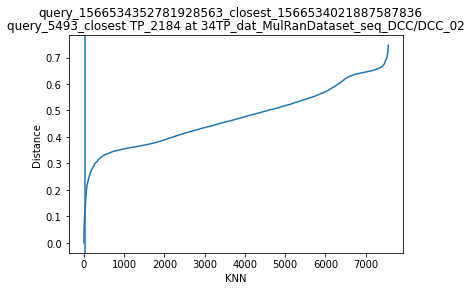

In [13]:
# Sorting
feat_dists_copy = list(feat_dists)
print("feat_dists_copy[:5] ", feat_dists_copy[:5], type(feat_dists_copy))
print("list_idx[:5] ",list_idx[:5])
feat_dists_copy, list_idx = zip(*sorted(zip(feat_dists_copy, list_idx)))
print("après tri")
print("feat_dists_copy[:5] ", feat_dists_copy[:5], type(feat_dists_copy))
print("list_idx[:5] ",list_idx[:5])

# Draw min
print('indice '+str(TP_idx), list_idx.index(TP_idx))

plt.figure()
plt.plot(feat_dists_copy)
plt.axvline(x = list_idx.index(TP_idx) )

if 'Kitti' in cfg.eval_dataset:
    plt.title('query_'+str(query_idx)+', closest TP : '+str(TP_idx)+' at '+str(list_idx.index(TP_idx)) + 'TP_dataset_'+str(cfg.eval_dataset)+'_seq_'+str(eval_seq)  )
    plt.xlabel('KNN')
    plt.ylabel('Distance')

elif 'MulRan' in cfg.eval_dataset:
    plt.title('query_'+str(query_idx)+'_closest TP_'+str(TP_idx)+' at '+str(list_idx.index(TP_idx)) + 'TP_dat_'+str(cfg.eval_dataset)+'_seq_'+str(eval_seq)  )
    plt.suptitle('query_'+str(name_dict[query_idx])+'_closest_'+str(name_dict[TP_idx]))
    plt.xlabel('KNN')
    plt.ylabel('Distance')